In [1]:
# 1. Importing libraries and preparing data
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [2]:
# 2. Load dataset
df = pd.read_csv(r"C:\Users\anony\Downloads\cleansed_ecommerce_with_traffic.csv")

In [3]:
# 3. Data preparation
# Load data
# Fix category typos
df['category'] = df['category'].replace({
    'Fashoin': 'Fashion'})
# Harmonize payment method
df['payment_method'] = df['payment_method'].replace({
    'creditcard': 'credit card'})
# Remove rows with non-positive quantity
df = df[df['quantity'] > 0]
# Calculate revenue
df['revenue'] = df['price'] * df['quantity']
# Parse dates
df['order_date'] = pd.to_datetime(df['order_date'])
df['ship_date'] = pd.to_datetime(df['ship_date'])
# Calculate delivery time in days
df['delivery_time'] = (df['ship_date'] - df['order_date']).dt.days
# Select relevant features
features = [
    'discount', 
    'review_rating', 
    'page_views', 
    'sessions', 
    'bounce_rate', 
    'avg_session_duration', 
    'delivery_time', 
    'revenue'
]
df_model = df[features].copy()
# Fill missing values with 0
df_model = df_model.fillna(0)
# Standardize features
scaler = StandardScaler()
X = df_model.drop('revenue', axis=1)
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
# Add revenue back for easy plotting
df_scaled = X_scaled.copy()
df_scaled['revenue'] = df_model['revenue']


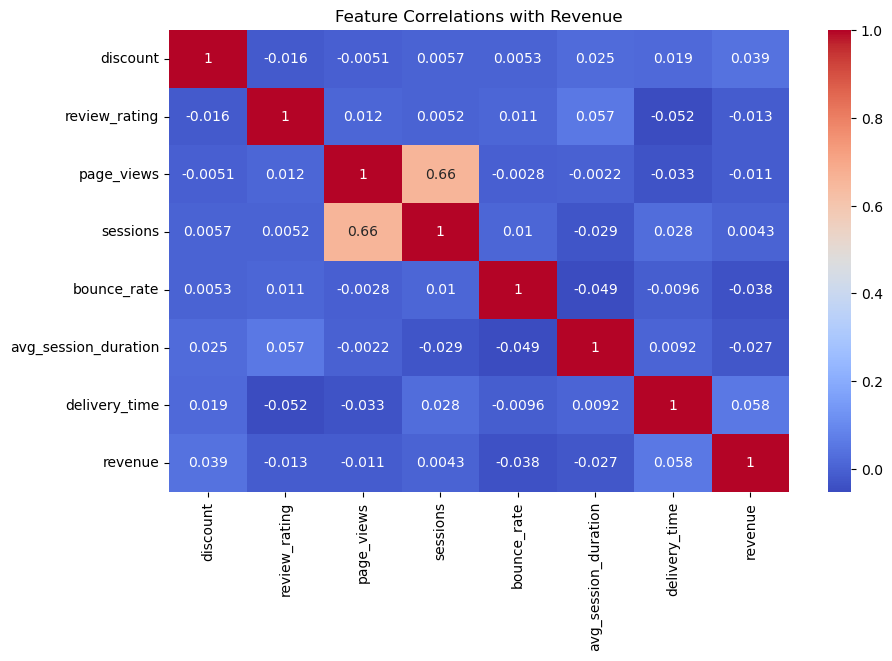

In [4]:
# Plot correlation heatmap
plt.figure(figsize=(10, 6))
corr = df_scaled.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Feature Correlations with Revenue")
plt.show()

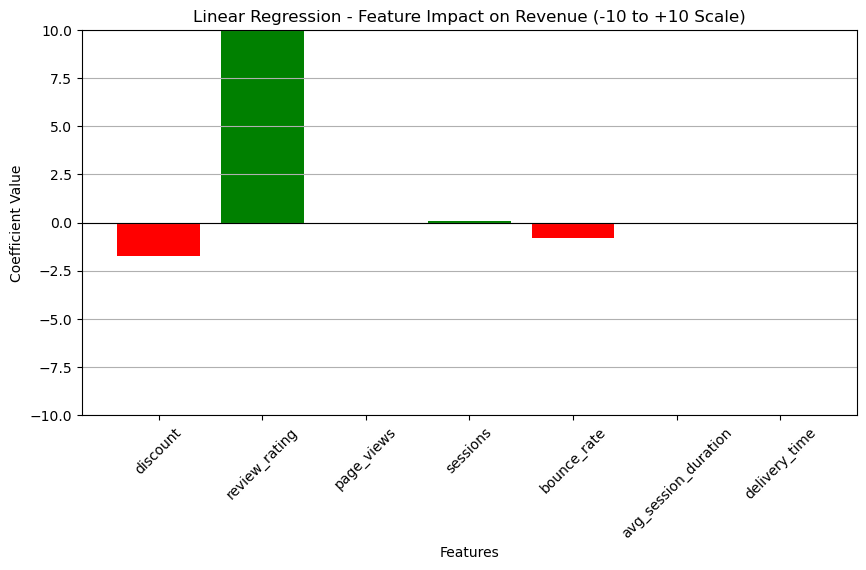

Linear Regression Coefficients:
discount: -1.7335
review_rating: 10.9719
page_views: 0.0005
sessions: 0.0615
bounce_rate: -0.7990
avg_session_duration: -0.0184
delivery_time: -0.0060


In [5]:
# Features and target
X = df_model.drop('revenue', axis=1)
y = df_model['revenue']
# Fit Linear Regression
lr = LinearRegression()
lr.fit(X, y)
lr_coefs = lr.coef_
# Plot
plt.figure(figsize=(10, 5))
bars = plt.bar(X.columns, lr_coefs, color=['green' if c > 0 else 'red' for c in lr_coefs])
plt.axhline(0, color='black', linewidth=0.8)  # baseline at 0
# Set y-axis limits with some padding
ymin = min(lr_coefs) - 1
ymax = max(lr_coefs) + 1
plt.ylim(ymin, ymax)
# Labels and title
plt.ylabel("Coefficient Value")
plt.xlabel("Features")
plt.title("Linear Regression - Feature Impact on Revenue (-10 to +10 Scale)")
# Optional: If you want a fixed range like -10 to +10 regardless of actual coefficients:
plt.ylim(-10, 10)
# Rotate feature labels for readability
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()
# Print coefficients for clarity
print("Linear Regression Coefficients:")
for feature, coef in zip(X.columns, lr_coefs):
    print(f"{feature}: {coef:.4f}")

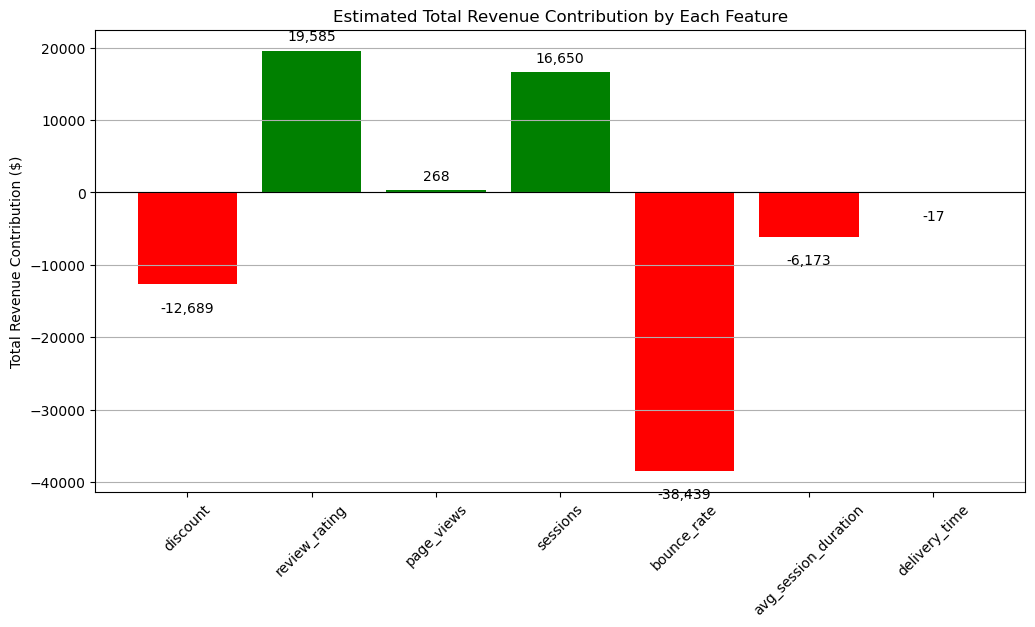

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Your features and coefficients
features = ['discount', 'review_rating', 'page_views', 'sessions', 'bounce_rate', 'avg_session_duration', 'delivery_time']
coefficients = np.array([-1.7335, 10.9719, 0.0005, 0.0615, -0.7990, -0.0184, -0.0060])

# Sum of each feature's values across the dataset
feature_sums = df_model[features].sum().values

# Calculate total revenue contribution by each feature
feature_contributions = coefficients * feature_sums

# Colors: green for positive contributions, red for negative
colors = ['green' if x > 0 else 'red' for x in feature_contributions]

plt.figure(figsize=(12,6))
bars = plt.bar(features, feature_contributions, color=colors)
plt.axhline(0, color='black', linewidth=0.8)
plt.ylabel('Total Revenue Contribution ($)')
plt.title('Estimated Total Revenue Contribution by Each Feature')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Annotate bars with values
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height:,.0f}', 
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 5 if height > 0 else -12), 
                 textcoords='offset points',
                 ha='center', va='bottom' if height > 0 else 'top')

plt.show()


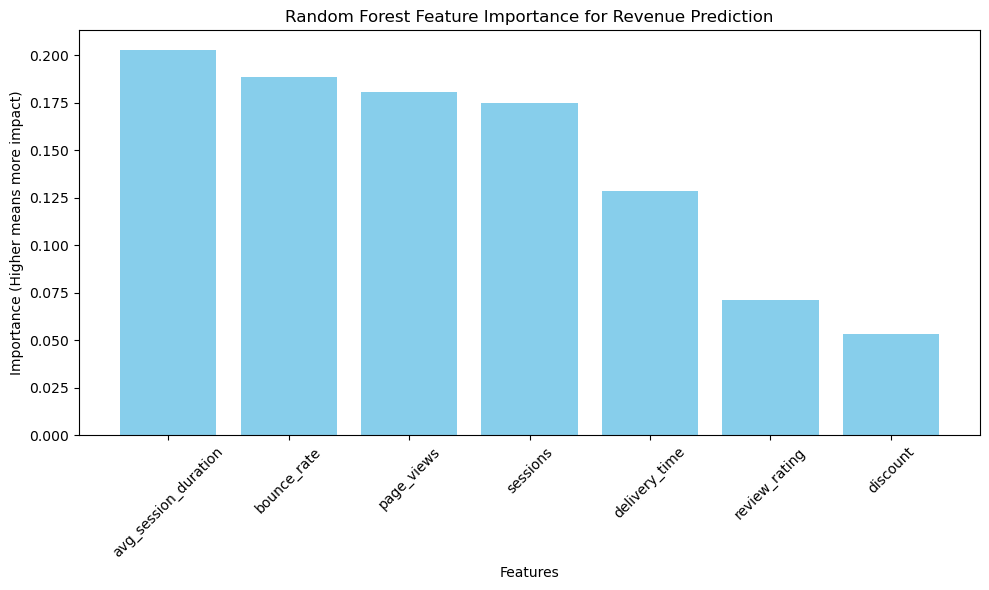

In [7]:
# And key features + target revenue are:
features = ['discount', 'review_rating', 'page_views', 'sessions', 'bounce_rate', 'avg_session_duration', 'delivery_time']
target = 'revenue'

# Prepare X and y
X = df[features]
y = df[target]

# Train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X, y)

# Get feature importances
importances = rf_model.feature_importances_

# Create a DataFrame for visualization
feat_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10,6))
plt.bar(feat_importance_df['Feature'], feat_importance_df['Importance'], color='skyblue')
plt.title('Random Forest Feature Importance for Revenue Prediction')
plt.ylabel('Importance (Higher means more impact)')
plt.xlabel('Features')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Mean Absolute Error (MAE): 393.62
R-squared (R2): -0.12


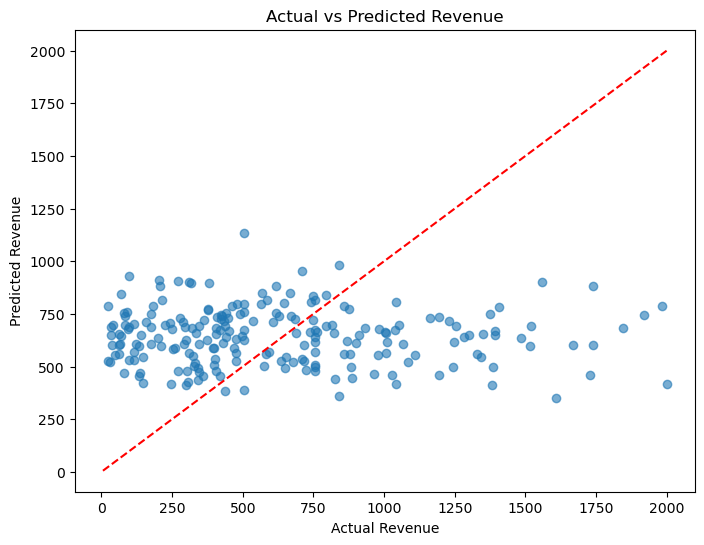

In [8]:
# Features and target
features = ['discount', 'review_rating', 'page_views', 'sessions', 'bounce_rate', 'avg_session_duration', 'delivery_time']
target = 'revenue'

X = df[features]
y = df[target]

# 1. Split data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Train Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# 3. Predict on test set
y_pred = rf_model.predict(X_test)

# 4. Evaluate performance
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R2): {r2:.2f}")

# Optional: plot actual vs predicted revenue
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.xlabel("Actual Revenue")
plt.ylabel("Predicted Revenue")
plt.title("Actual vs Predicted Revenue")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')  # diagonal line
plt.show()

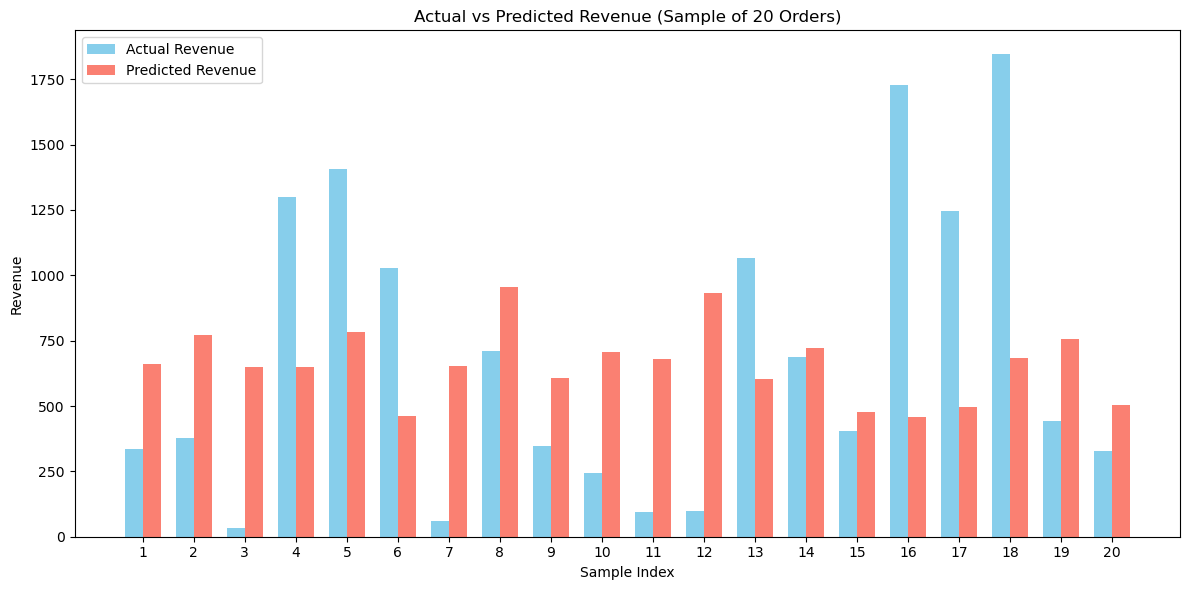

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assume you already have y_test and y_pred from the predictive model

# Convert y_test to a DataFrame for easy plotting and align index
y_test = pd.Series(y_test).reset_index(drop=True)
y_pred = pd.Series(y_pred).reset_index(drop=True)

# Select first 20 samples for clear visualization
n = 20
actual = y_test[:n]
predicted = y_pred[:n]

# Set positions and width for bars
ind = np.arange(n)
width = 0.35

plt.figure(figsize=(12,6))

# Plot actual revenue bars
plt.bar(ind, actual, width, label='Actual Revenue', color='skyblue')

# Plot predicted revenue bars, shifted by width
plt.bar(ind + width, predicted, width, label='Predicted Revenue', color='salmon')

plt.xlabel('Sample Index')
plt.ylabel('Revenue')
plt.title('Actual vs Predicted Revenue (Sample of 20 Orders)')
plt.xticks(ind + width / 2, [str(i) for i in range(1, n+1)])
plt.legend()
plt.tight_layout()
plt.show()


In [10]:
# Let's assume we have these:
# model_rf: trained Random Forest model
# X_test_scaled: scaled test data (DataFrame)
# y_test: actual revenue values
# Train Random Forest model
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train_scaled, y_train)
# Baseline predictions
baseline_pred = model_rf.predict(X_test_scaled)
baseline_revenue = np.mean(baseline_pred)

# Store results
factor_names = X_test_scaled.columns
baseline_revenues = []
remove_revenues = []
max_revenues = []

# Loop through each factor
for factor in factor_names:
    # Baseline revenue for comparison
    baseline_revenues.append(baseline_revenue)

    # Scenario 1: Remove Factor (set to 0)
    X_test_remove = X_test_scaled.copy()
    X_test_remove[factor] = 0
    remove_pred = model_rf.predict(X_test_remove)
    remove_revenue = np.mean(remove_pred)
    remove_revenues.append(remove_revenue)

    # Scenario 2: Max Factor (set to max)
    X_test_max = X_test_scaled.copy()
    X_test_max[factor] = X_test_scaled[factor].max()
    max_pred = model_rf.predict(X_test_max)
    max_revenue = np.mean(max_pred)
    max_revenues.append(max_revenue)

# Create DataFrame for plotting
df_plot = pd.DataFrame({
    'Factor': factor_names,
    'Baseline Revenue': baseline_revenues,
    'Remove Factor Revenue': remove_revenues,
    'Max Factor Revenue': max_revenues
})

# Plotting
x = np.arange(len(factor_names))
width = 0.25

plt.figure(figsize=(14,6))
plt.bar(x - width, df_plot['Baseline Revenue'], width, label='Baseline')
plt.bar(x, df_plot['Remove Factor Revenue'], width, label='Remove Factor')
plt.bar(x + width, df_plot['Max Factor Revenue'], width, label='Max Factor')

plt.xticks(x, factor_names, rotation=45)
plt.xlabel('Factors')
plt.ylabel('Average Predicted Revenue')
plt.title('Simulated Impact of Each Factor on Revenue')
plt.legend()
plt.tight_layout()
plt.show()


NameError: name 'X_train_scaled' is not defined

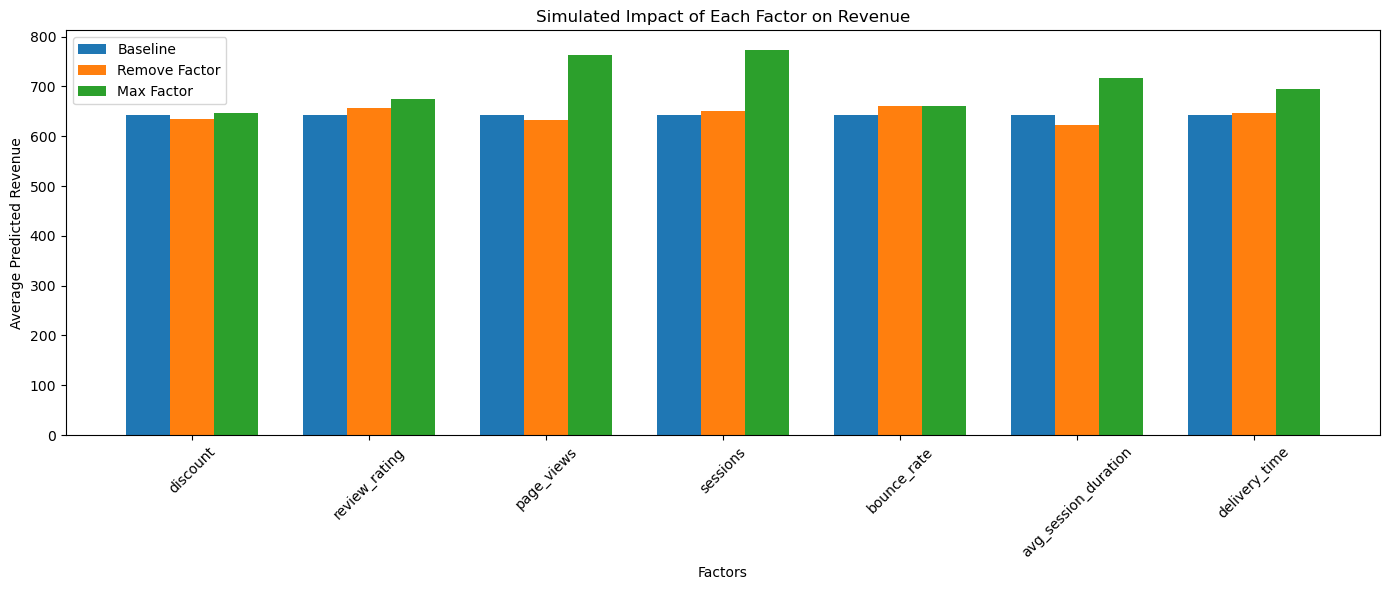

In [11]:
# Scale features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=features)

# Train-test split
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42)

# Train Random Forest model
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train_scaled, y_train)

# Baseline predictions
baseline_pred = model_rf.predict(X_test_scaled)
baseline_revenue = np.mean(baseline_pred)

# Simulate factor impacts
factor_names = features
baseline_revenues = []
remove_revenues = []
max_revenues = []

for factor in factor_names:
    baseline_revenues.append(baseline_revenue)

    # Remove Factor: set to 0
    X_test_remove = X_test_scaled.copy()
    X_test_remove[factor] = 0
    remove_pred = model_rf.predict(X_test_remove)
    remove_revenue = np.mean(remove_pred)
    remove_revenues.append(remove_revenue)

    # Max Factor: set to max
    X_test_max = X_test_scaled.copy()
    X_test_max[factor] = X_test_scaled[factor].max()
    max_pred = model_rf.predict(X_test_max)
    max_revenue = np.mean(max_pred)
    max_revenues.append(max_revenue)

# Create DataFrame
df_plot = pd.DataFrame({
    'Factor': factor_names,
    'Baseline Revenue': baseline_revenues,
    'Remove Factor Revenue': remove_revenues,
    'Max Factor Revenue': max_revenues
})

# Plotting
x = np.arange(len(factor_names))
width = 0.25

plt.figure(figsize=(14,6))
plt.bar(x - width, df_plot['Baseline Revenue'], width, label='Baseline')
plt.bar(x, df_plot['Remove Factor Revenue'], width, label='Remove Factor')
plt.bar(x + width, df_plot['Max Factor Revenue'], width, label='Max Factor')

plt.xticks(x, factor_names, rotation=45)
plt.xlabel('Factors')
plt.ylabel('Average Predicted Revenue')
plt.title('Simulated Impact of Each Factor on Revenue')
plt.legend()
plt.tight_layout()
plt.show()

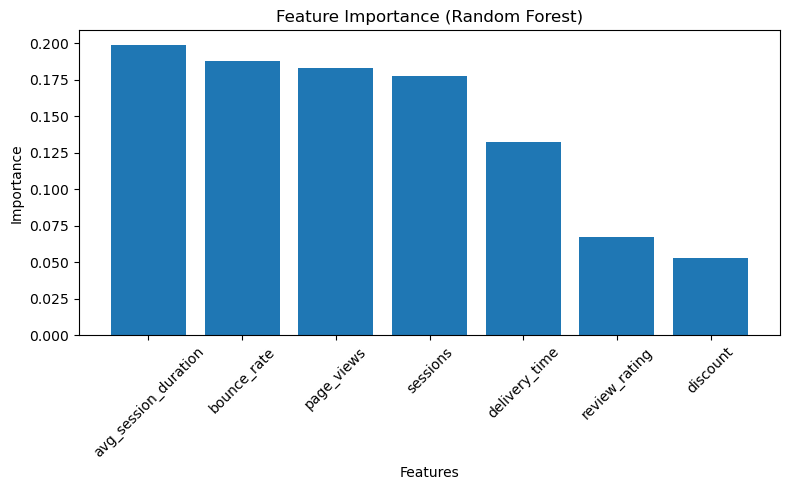

In [13]:
# Check feature importances from Random Forest
importances = model_rf.feature_importances_
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(8,5))
plt.bar(importance_df['Feature'], importance_df['Importance'])
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importance (Random Forest)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


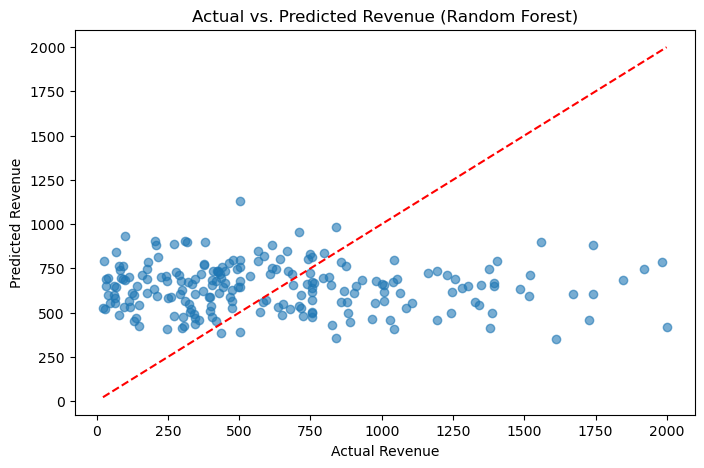

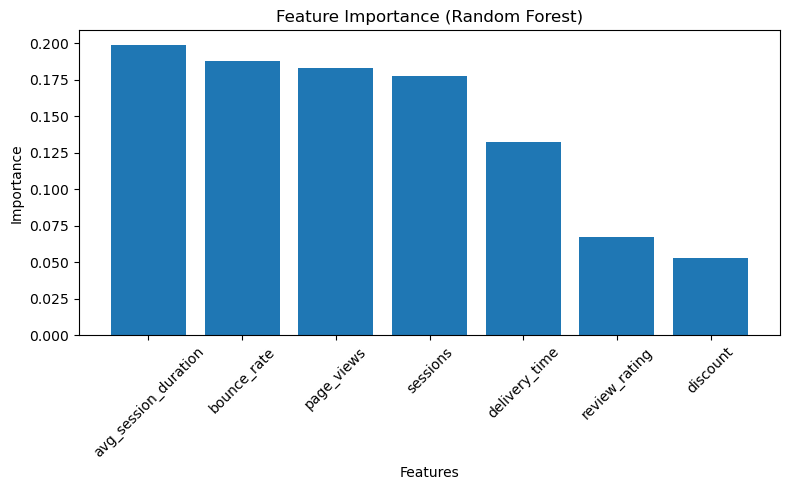

C:\Users\anony\AppData\Local\Temp\ipykernel_4672\1754964042.py:98: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Scenario', y='Predicted Revenue', data=results_df, palette='viridis')


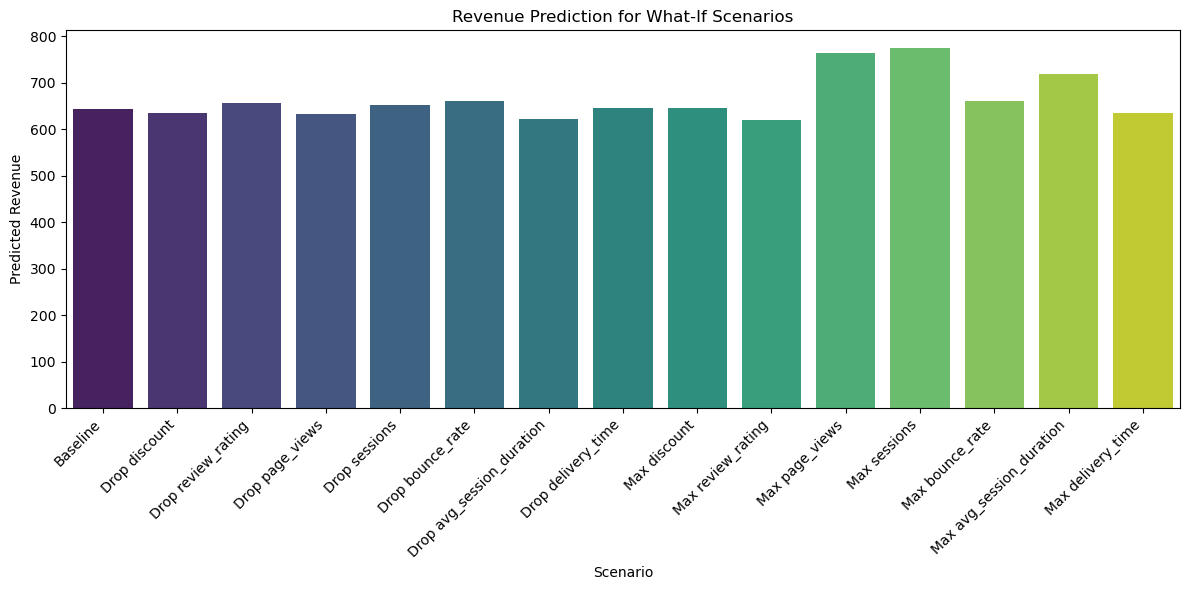

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Sample DataFrame (replace this with your actual df)
# df = pd.read_csv("your_data.csv")

# Select features and target
features = ['discount', 'review_rating', 'page_views', 'sessions', 
            'bounce_rate', 'avg_session_duration', 'delivery_time']
target = 'revenue'

X = df[features]
y = df[target]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42)

# Train Random Forest
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)

# Predict on test set
y_pred = model_rf.predict(X_test)

# Plot Actual vs Predicted (for performance overview)
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.xlabel("Actual Revenue")
plt.ylabel("Predicted Revenue")
plt.title("Actual vs. Predicted Revenue (Random Forest)")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()

# ------------------------------
# Feature Importance
importances = model_rf.feature_importances_
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8,5))
plt.bar(importance_df['Feature'], importance_df['Importance'])
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importance (Random Forest)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ------------------------------
# What-If Simulation

# Predict baseline revenue (mean of all predictions)
baseline_pred = model_rf.predict(X_test).mean()

# Initialize results
results = {'Scenario': [], 'Predicted Revenue': []}

# Baseline
results['Scenario'].append('Baseline')
results['Predicted Revenue'].append(baseline_pred)

# Dropping each factor (set to 0)
X_test_dropped = X_test.copy()
for i, feature in enumerate(features):
    X_temp = X_test.copy()
    X_temp[:, i] = 0  # Drop feature
    dropped_pred = model_rf.predict(X_temp).mean()
    results['Scenario'].append(f'Drop {feature}')
    results['Predicted Revenue'].append(dropped_pred)

# Maximizing each factor (set to its max value in X_test)
X_test_max = X_test.copy()
for i, feature in enumerate(features):
    X_temp = X_test.copy()
    X_temp[:, i] = X_test[:, i].max()
    max_pred = model_rf.predict(X_temp).mean()
    results['Scenario'].append(f'Max {feature}')
    results['Predicted Revenue'].append(max_pred)

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Plot bar chart
plt.figure(figsize=(12,6))
sns.barplot(x='Scenario', y='Predicted Revenue', data=results_df, palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Predicted Revenue')
plt.xlabel('Scenario')
plt.title('Revenue Prediction for What-If Scenarios')
plt.tight_layout()
plt.show()
